# Model Evaluation

In this notebook, we will evaluate the performance of our models for the [Vehicles.csv](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data) dataset. We will assess various models’ effectiveness in predicting used car prices, using a range of evaluation metrics. Our goal is to determine the most accurate and reliable model for this task.

By the end of this notebook, we will identify the strongest model for predicting used car prices, to be evaluated for further insights.

### Loading Tools and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os, zipfile
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

with zipfile.ZipFile('../data/clean_vehicles.csv.zip', 'r') as zipf:
    zipf.extract('clean_vehicles.csv', path='../data')

data = pd.read_csv('../data/clean_vehicles.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55806 entries, 0 to 55805
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         55806 non-null  int64  
 1   year          55806 non-null  int64  
 2   manufacturer  55806 non-null  object 
 3   model         55805 non-null  object 
 4   condition     55806 non-null  object 
 5   odometer      55806 non-null  float64
 6   cylinders     55806 non-null  object 
 7   fuel          55806 non-null  object 
 8   title_status  55806 non-null  object 
 9   transmission  55806 non-null  object 
 10  drive         55806 non-null  object 
 11  type          55806 non-null  object 
 12  paint_color   55806 non-null  object 
 13  state         55806 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 6.0+ MB


## Model Build

In [2]:
df = data.copy()
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['odometer']
ordinal_features = ['year', 'condition', 'title_status']
categorical_features = ['manufacturer', 'model', 'cylinders', 'fuel',
                        'transmission', 'drive', 'type', 'paint_color', 'state']

numerical_transformer = StandardScaler()
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)
    ])

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.99)),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42))
])

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_error = mean_squared_error(y_test, rf_predictions)
error_price = np.sqrt(rf_error)
print(error_price)

2207.730847976429


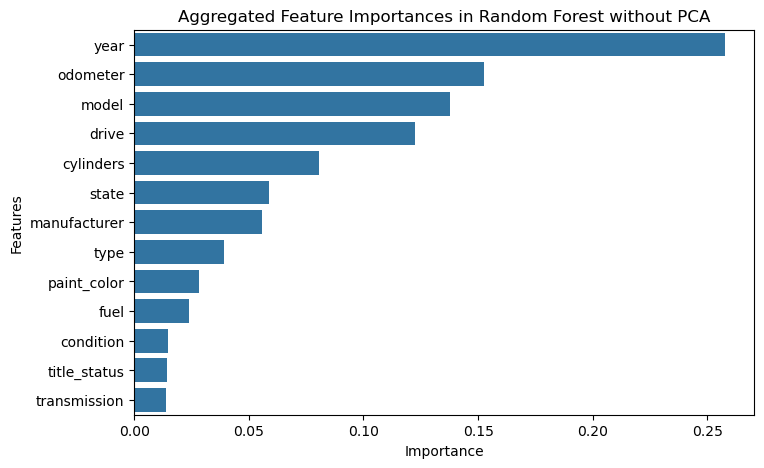

In [3]:
rf_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42))
])

rf_model_no_pca.fit(X_train, y_train)

importances_no_pca = rf_model_no_pca.named_steps['model'].feature_importances_
preprocessor = rf_model_no_pca.named_steps['preprocessor']
encoded_cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names_no_pca = numerical_features + ordinal_features + encoded_cat_features

importances_dict = dict(zip(feature_names_no_pca, importances_no_pca))
aggregated_importances = {feature: 0 for feature in numerical_features + ordinal_features + categorical_features}
for feature, importance in importances_dict.items():
    matched = False
    for cat_feature in categorical_features:
        if feature.startswith(cat_feature):
            aggregated_importances[cat_feature] += importance
            matched = True
            break
    if not matched:
        aggregated_importances[feature] += importance

sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)
final_feature_names, final_importances = zip(*sorted_importances)

plt.figure(figsize=(8, 5))
sns.barplot(x=final_importances, y=final_feature_names)
plt.title("Aggregated Feature Importances in Random Forest without PCA")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Evaluate Model

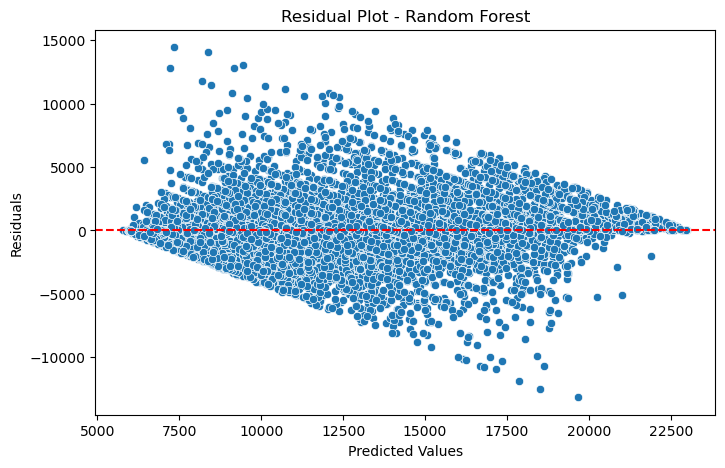

<Figure size 640x480 with 0 Axes>

In [8]:
# Plotting Residual Plot for Random Forest
residuals_rf = y_test - rf_predictions
plt.figure(figsize=(8,5))
sns.scatterplot(x=rf_predictions, y=residuals_rf)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot - Random Forest')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
plt.savefig('residual_plot.png')

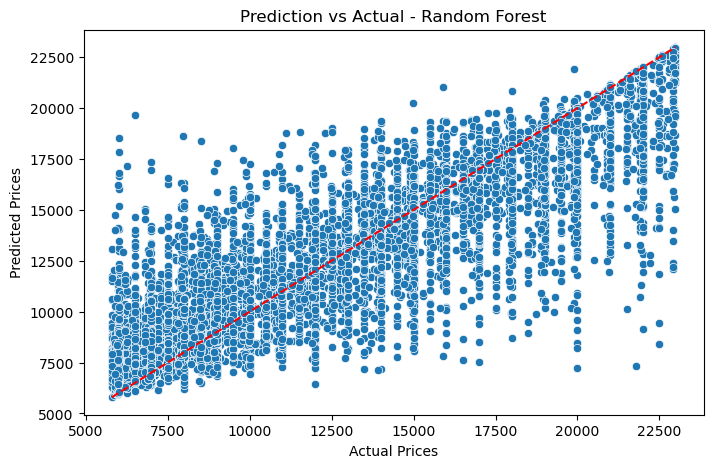

<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting Prediction vs Actual Plot for Random Forest
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=rf_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediction vs Actual - Random Forest')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()
plt.savefig('pred_vs_actual.png')

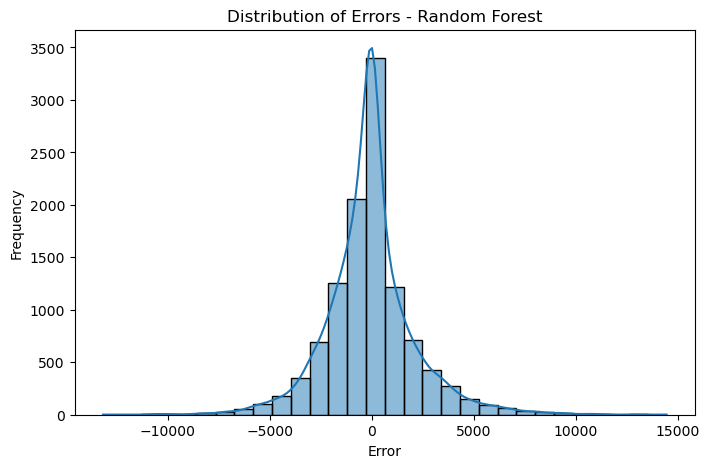

<Figure size 640x480 with 0 Axes>

In [10]:
# Plotting Distribution of Errors for Random Forest
plt.figure(figsize=(8,5))
sns.histplot(residuals_rf, bins=30, kde=True)
plt.title('Distribution of Errors - Random Forest')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()
plt.savefig('error_distribution.png')

In [13]:
# Add predictions and actual prices to the test set for plotting
X_test['predicted_price'] = rf_predictions
X_test['actual_price'] = y_test.values

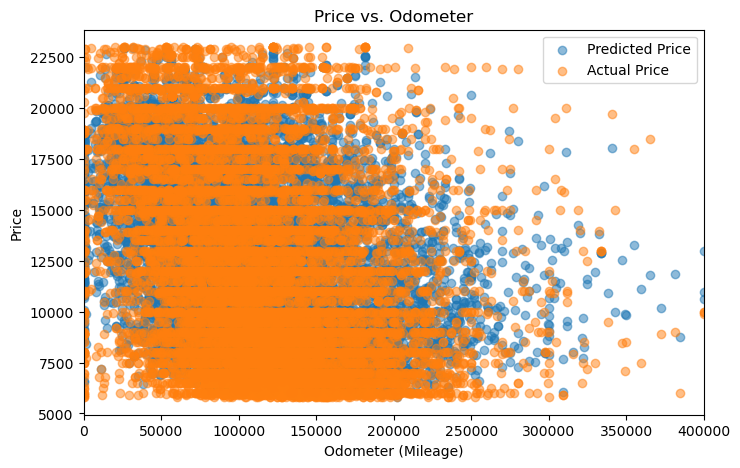

In [15]:
# Plot 1: Price vs. Odometer
plt.figure(figsize=(8,5))
plt.scatter(X_test['odometer'], X_test['predicted_price'], alpha=0.5, label='Predicted Price')
plt.scatter(X_test['odometer'], X_test['actual_price'], alpha=0.5, label='Actual Price')
plt.xlabel('Odometer (Mileage)')
plt.xlim(0,400000)
plt.ylabel('Price')
plt.title('Price vs. Odometer')
plt.legend()
plt.show()

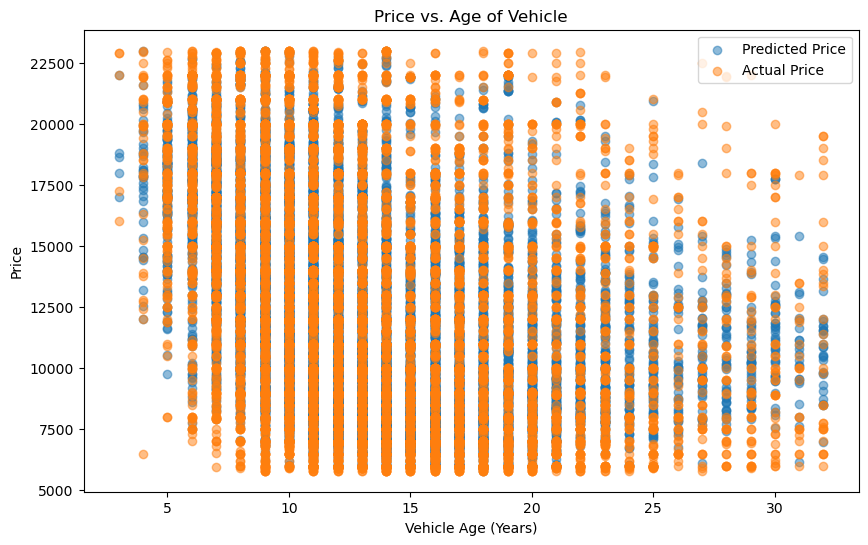

In [16]:
# Plot 2: Price vs. Age of Vehicle
plt.figure(figsize=(10, 6))
vehicle_age = 2024 - X_test['year']
plt.scatter(vehicle_age, X_test['predicted_price'], alpha=0.5, label='Predicted Price')
plt.scatter(vehicle_age, X_test['actual_price'], alpha=0.5, label='Actual Price')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Price')
plt.title('Price vs. Age of Vehicle')
plt.legend()
plt.show()

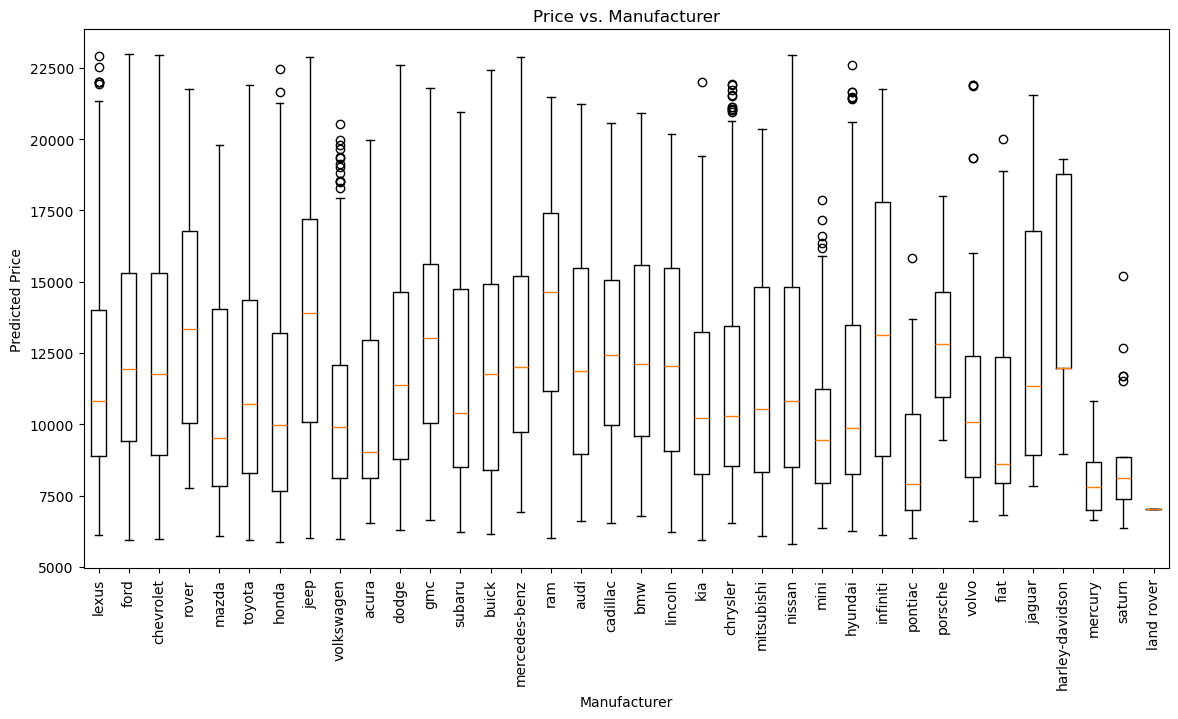

In [17]:
# Plot 3: Price vs. Manufacturer
plt.figure(figsize=(14, 7))
df_manufacturer = X_test.copy()
df_manufacturer['manufacturer'] = X_test['manufacturer']
df_manufacturer['predicted_price'] = rf_predictions
plt.boxplot([df_manufacturer[df_manufacturer['manufacturer'] == manufacturer]['predicted_price'] for manufacturer in df_manufacturer['manufacturer'].unique()], labels=df_manufacturer['manufacturer'].unique())
plt.xlabel('Manufacturer')
plt.ylabel('Predicted Price')
plt.title('Price vs. Manufacturer')
plt.xticks(rotation=90)
plt.show()

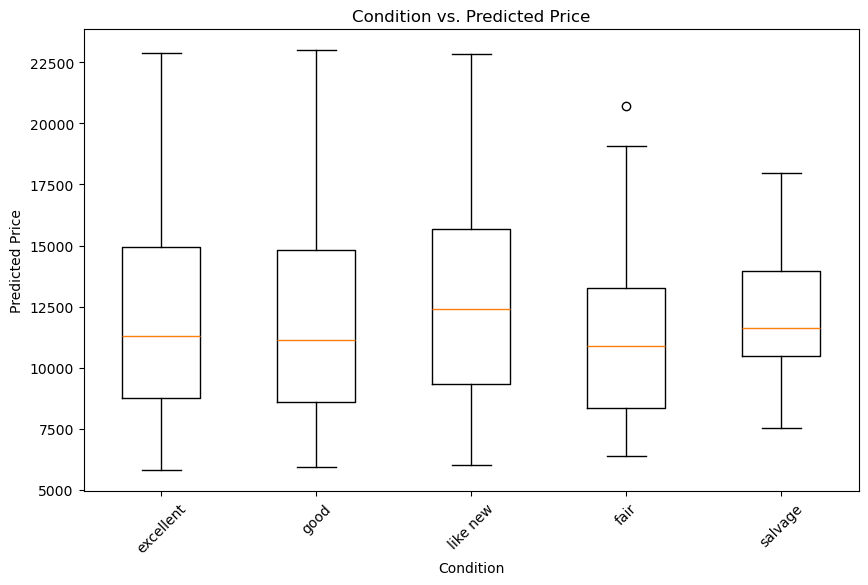

In [23]:
# Plot 4: Condition vs. Predicted Price
plt.figure(figsize=(10, 6))
df_condition = X_test.copy()

df_condition['condition'] = X_test['condition']
df_condition['predicted_price'] = rf_predictions
plt.boxplot([df_condition[df_condition['condition'] == condition]['predicted_price'] for condition in df_condition['condition'].unique()], labels=df_condition['condition'].unique())
plt.xlabel('Condition')
plt.ylabel('Predicted Price')
plt.title('Condition vs. Predicted Price')
plt.xticks(rotation=45)
plt.show()

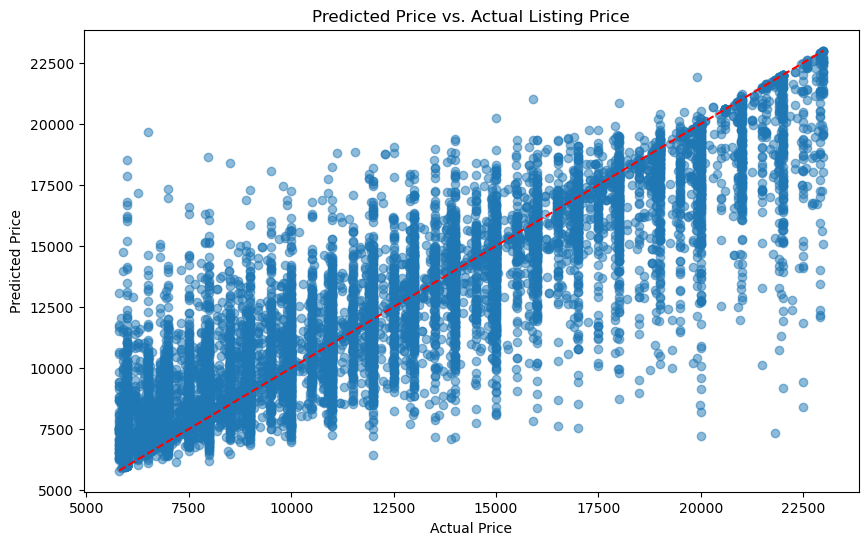

In [19]:
# Plot 5: Predicted Price vs. Actual Listing Price
plt.figure(figsize=(10, 6))
plt.scatter(X_test['actual_price'], X_test['predicted_price'], alpha=0.5)
plt.plot([min(X_test['actual_price']), max(X_test['actual_price'])], [min(X_test['actual_price']), max(X_test['actual_price'])], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted Price vs. Actual Listing Price')
plt.show()

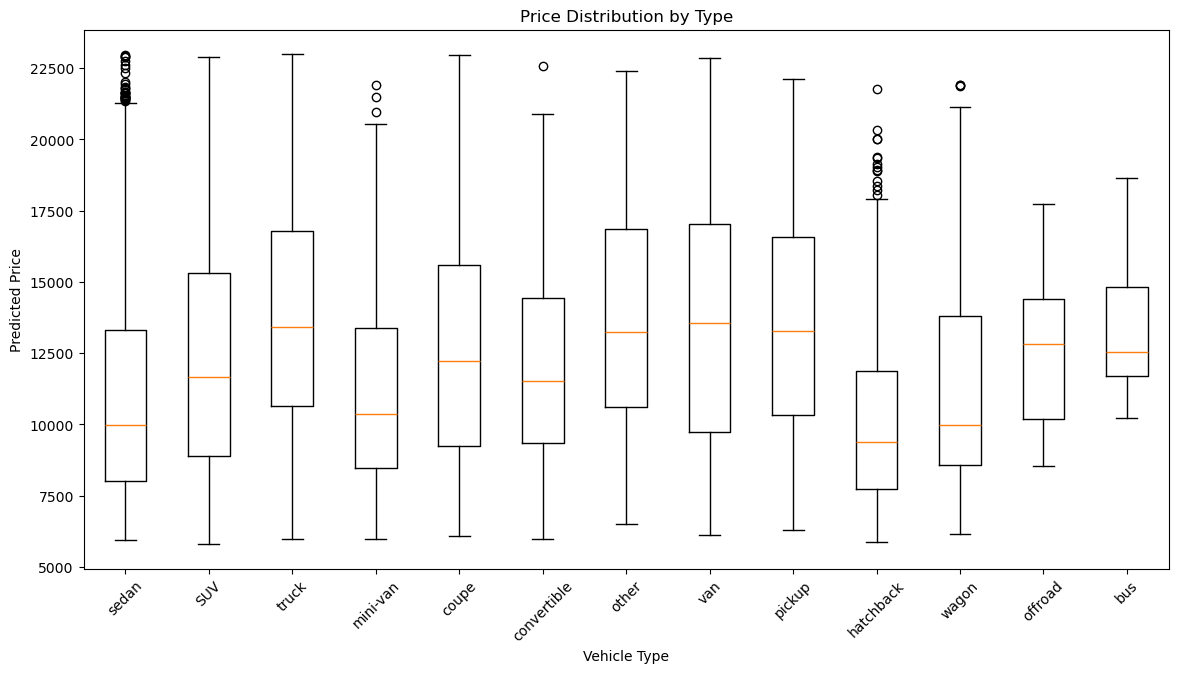

In [20]:
# Plot 6: Price Distribution by Type and Drive
plt.figure(figsize=(14, 7))
df_type_drive = X_test.copy()
df_type_drive['type'] = X_test['type']
df_type_drive['drive'] = X_test['drive']
df_type_drive['predicted_price'] = rf_predictions
plt.boxplot([df_type_drive[df_type_drive['type'] == vehicle_type]['predicted_price'] for vehicle_type in df_type_drive['type'].unique()], labels=df_type_drive['type'].unique())
plt.xlabel('Vehicle Type')
plt.ylabel('Predicted Price')
plt.title('Price Distribution by Type')
plt.xticks(rotation=45)
plt.show()

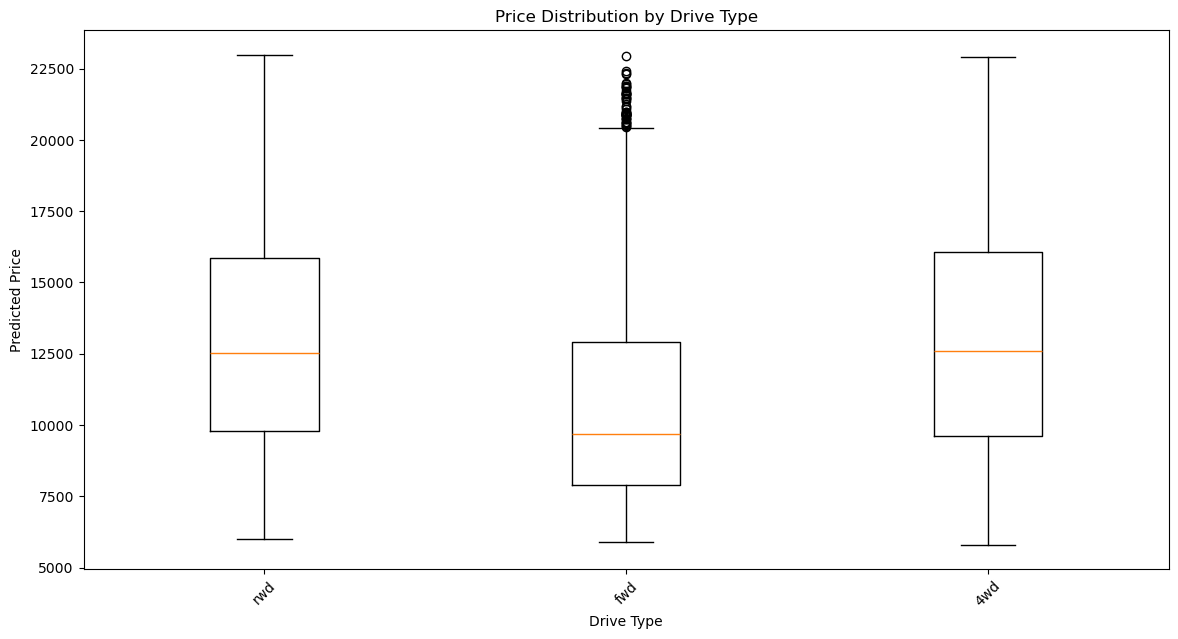

In [21]:
plt.figure(figsize=(14, 7))
plt.boxplot([df_type_drive[df_type_drive['drive'] == drive]['predicted_price'] for drive in df_type_drive['drive'].unique()], labels=df_type_drive['drive'].unique())
plt.xlabel('Drive Type')
plt.ylabel('Predicted Price')
plt.title('Price Distribution by Drive Type')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Plot 1: Predicted Price vs. Odometer for Different Conditions
plt.figure(figsize=(12, 6))
for condition in X_test_full['condition'].unique():
    subset = X_test_full[X_test_full['condition'] == condition]
    plt.scatter(subset['odometer'], subset['actual_price'], alpha=0.5, label=f"{condition} (Actual)")
    plt.scatter(subset['odometer'], subset['predicted_price'], alpha=0.5, label=f"{condition} (Predicted)", marker='x')

plt.xlabel('Odometer (Mileage)')
plt.ylabel('Price')
plt.title('Predicted Price vs. Odometer by Condition')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X_test_full' is not defined

<Figure size 1200x600 with 0 Axes>

In [4]:
try:
    print('Script Executed Successfully')
except:
    print('FAILED')

Script Executed Successfully
